# Image Classification With PyTorch

The CIFAR10 dataset has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [1]:
import torch, torchvision

In [2]:
import torchvision.transforms as transforms

### 1. Load and Normalize CIFAR10

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [4]:
batch_size=4

In [5]:
trainset=torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)

Files already downloaded and verified


In [6]:
trainLoader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)

In [7]:
testset=torchvision.datasets.CIFAR10(root="./data", train=False,download=True, transform=transform)

Files already downloaded and verified


In [8]:
testLoader=torch.utils.data.DataLoader(testset,batch_size=batch_size, shuffle=True,num_workers=2)

In [9]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

In [21]:
dataiter=iter(trainLoader)

In [22]:
images,labels=dataiter.next()

In [23]:
labels

tensor([9, 0, 2, 8])

     truck      plane       bird       ship


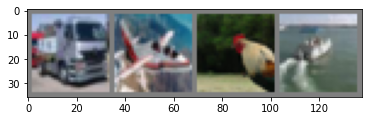

In [29]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%10s' % classes[labels[j]] for j in range(batch_size)))

In [32]:
import torch.nn as nn
import torch.nn.functional as F

In [43]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    
    def forward(self,x):
        x=self.conv1(x)
        x=F.relu(x)
        x=self.pool(x)
        x=self.pool(F.relu(self.conv2(x)))
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
cnn=CNN()              

In [41]:
def train(dataLoader,optimizer,criterion):
    for epoch in range(2):
        running_loss=0.0
        for i, data in enumerate(dataLoader):
            # data is a list of [inputs, labels]
            inputs,labels=data

            # Zero the param gradients
            optimizer.zero_grad()

            #forward+backward+optimize
            outputs=cnn(inputs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            
            running_loss+=loss.item()
            if(i%2000==1999):
                print(f"Epoch:{epoch+1}\nLoss:{running_loss/2000}")
                running_loss=0
            


In [44]:
train(trainLoader,torch.optim.SGD(cnn.parameters(),lr=0.001,momentum=0.9), nn.CrossEntropyLoss())

Epoch:1
Loss:2.23962066090107
Epoch:1
Loss:1.8878826819360257
Epoch:1
Loss:1.6785638238489629
Epoch:1
Loss:1.546180781841278
Epoch:1
Loss:1.5054641077518462
Epoch:1
Loss:1.4683578306287528
Epoch:2
Loss:1.3994762207567693
Epoch:2
Loss:1.3761042757332325
Epoch:2
Loss:1.3234896130338312
Epoch:2
Loss:1.3350654425546526
Epoch:2
Loss:1.3035036581233144
Epoch:2
Loss:1.2659321514628827


In [46]:
PATH='./cifar_net.pth'
torch.save(cnn.state_dict(),PATH)

      deer      horse       bird      truck


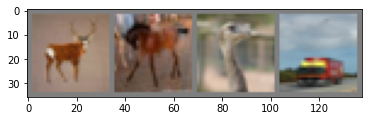

In [51]:
dataiter=iter(testLoader)
images,labels=dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

In [53]:
ConvNet=CNN()
ConvNet.load_state_dict(torch.load('./CIFAR10/cifar_net.pth'))

<All keys matched successfully>

In [54]:
outputs=ConvNet(images)

In [55]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   deer horse  deer  ship


In [56]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = ConvNet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [57]:
correct={classname:0 for classname in classes}
total={classname:0 for classname in classes}

with torch.no_grad():
    for data in testLoader:
        images,labels=data
        outputs=ConvNet(images)
        _,predictions=torch.max(outputs,1)
        for label, prediction in zip(labels,predictions):
            if(label==prediction):
                correct[classes[label]]+=1
            total[classes[label]]+=1

for classname, correctCount in correct.items():
    accuracy=100*float(correctCount)/total[classname]
    print(f"Accuracy for class {classname} is: {accuracy} %")

Accuracy for class plane is: 52.8 %
Accuracy for class car is: 79.2 %
Accuracy for class bird is: 39.9 %
Accuracy for class cat is: 43.6 %
Accuracy for class deer is: 38.6 %
Accuracy for class dog is: 26.1 %
Accuracy for class frog is: 63.3 %
Accuracy for class horse is: 59.6 %
Accuracy for class ship is: 82.7 %
Accuracy for class truck is: 47.2 %
